<a href="https://www.kaggle.com/code/ahana09/ps-s3e17-xgb-cat-lgbm?scriptVersionId=135260019" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import plotly.express as px

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer, OneHotEncoder

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

### Import Data

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s3e17/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e17/test.csv")
sub =pd.read_csv("/kaggle/input/playground-series-s3e17/sample_submission.csv")

In [3]:
train.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [4]:
train=train.drop(['id','Product ID'],axis=1)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Type                     136429 non-null  object 
 1   Air temperature [K]      136429 non-null  float64
 2   Process temperature [K]  136429 non-null  float64
 3   Rotational speed [rpm]   136429 non-null  int64  
 4   Torque [Nm]              136429 non-null  float64
 5   Tool wear [min]          136429 non-null  int64  
 6   Machine failure          136429 non-null  int64  
 7   TWF                      136429 non-null  int64  
 8   HDF                      136429 non-null  int64  
 9   PWF                      136429 non-null  int64  
 10  OSF                      136429 non-null  int64  
 11  RNF                      136429 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 12.5+ MB


In [6]:
train.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,299.862776,309.941070,1520.331110,40.348643,104.408901,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,1.862247,1.385173,138.736632,8.502229,63.965040,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
train['Type']=train['Type'].replace({"L":0,"M":1,"H":2})
test['Type']=test['Type'].replace({"L":0,"M":1,"H":2})

In [8]:
train.describe()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,0.366476,299.862776,309.941070,1520.331110,40.348643,104.408901,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,0.602480,1.862247,1.385173,138.736632,8.502229,63.965040,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,0.000000,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### EDA

array([[<Axes: title={'center': 'Type'}>,
        <Axes: title={'center': 'Air temperature [K]'}>,
        <Axes: title={'center': 'Process temperature [K]'}>],
       [<Axes: title={'center': 'Rotational speed [rpm]'}>,
        <Axes: title={'center': 'Torque [Nm]'}>,
        <Axes: title={'center': 'Tool wear [min]'}>],
       [<Axes: title={'center': 'Machine failure'}>,
        <Axes: title={'center': 'TWF'}>, <Axes: title={'center': 'HDF'}>],
       [<Axes: title={'center': 'PWF'}>, <Axes: title={'center': 'OSF'}>,
        <Axes: title={'center': 'RNF'}>]], dtype=object)

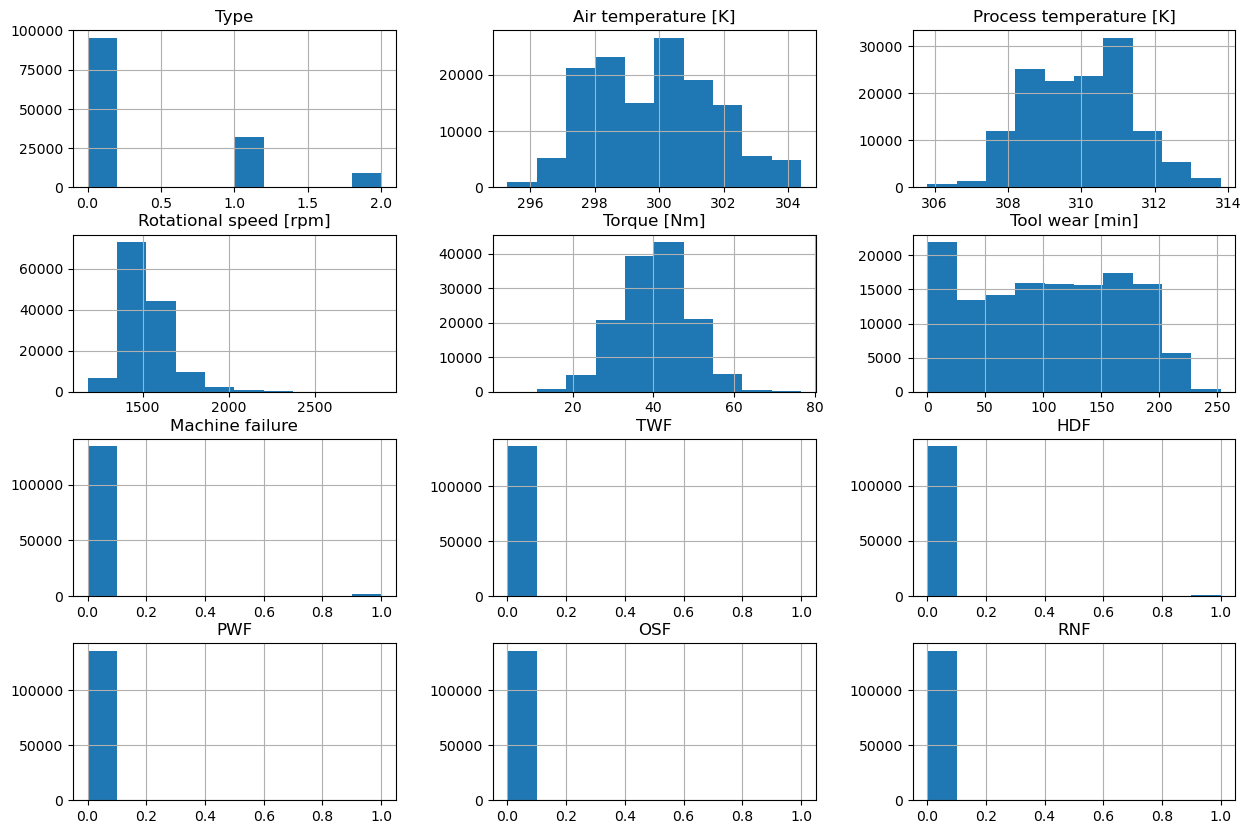

In [9]:
train.hist(figsize=(15,10))

In [ ]:
#drop=['PWF','OSF','RNF','HDF','TWF']

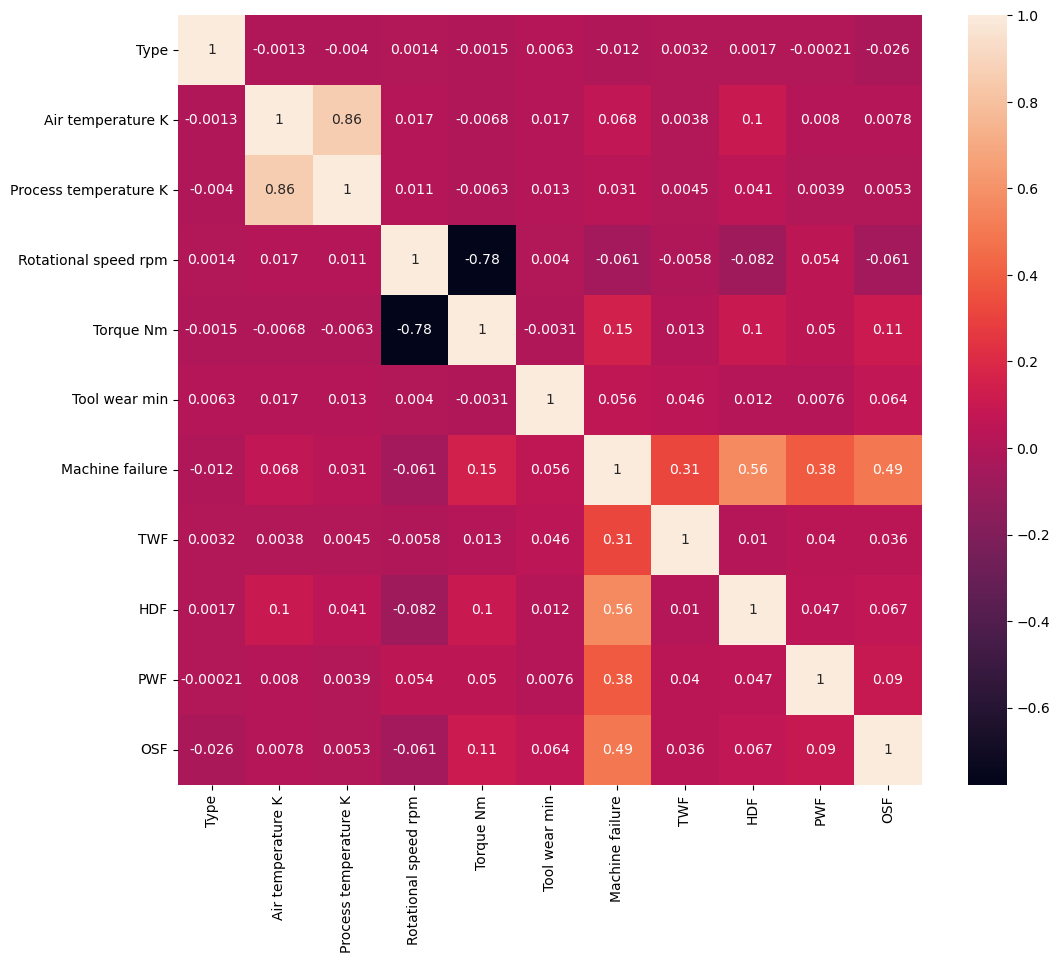

In [19]:
plt.figure(figsize=(12,10))
sns.heatmap(train.corr(),annot=True)
plt.show()

* Torque and Rotational Speed is highly correlated (-0.78)
* Air Temperature and Process Temperature is highly correlated (0.86)

### Data Preprocessing

In [11]:
train=train.drop('RNF',axis=1)

* As distribution of RNF is quite imbalanced and correlation between RNF and Machine Failure is very low(0.0014), I will drop this column

In [12]:
test=test.drop(['id','RNF','Product ID'], axis=1)

In [13]:
train.columns = train.columns.str.replace('[\[\]]', '', regex=True)
test.columns=test.columns.str.replace('[\[\]]', '', regex=True)

### Models

In [14]:
X = train.drop('Machine failure', axis=1)
y = train['Machine failure']

In [16]:
SPLITS = 10
RANDOM = 10
ESTIMATORS = 2000
clfs = []
scores = []
y_pred = []

In [ ]:
skf = StratifiedKFold(n_splits = SPLITS, shuffle = True, random_state = RANDOM)

for train_idx, test_idx in skf.split(X_bal, y_bal):
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]    
    y_train, y_test = y[train_idx], y[test_idx]    
    clf1 = XGBClassifier(n_estimators = ESTIMATORS,learning_rate = 0.087,tree_method='gpu_hist')
    clf1.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=20, verbose=False)
    preds = clf1.predict_proba(X_test)    
    clfs.append(clf1)
    scores.append(roc_auc_score(y_test, preds[:, 1]))
print(f'mean score: {np.mean(scores)}')

In [ ]:
skf = StratifiedKFold(n_splits = SPLITS, shuffle = True, random_state = RANDOM)

for train_idx, test_idx in skf.split(X_bal, y_bal:
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]    
    y_train, y_test = y[train_idx], y[test_idx]    
    clf2 = CatBoostClassifier(auto_class_weights='Balanced', n_estimators = ESTIMATORS, task_type="GPU")
    clf2.fit(X_train.values, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=20, verbose=False)
    preds = clf2.predict_proba(X_test.values)    
    clfs.append(clf2)
    scores.append(roc_auc_score(y_test, preds[:, 1]))
print(f'mean score: {np.mean(scores)}')

In [ ]:
skf = StratifiedKFold(n_splits = SPLITS, shuffle = True, random_state = RANDOM)

for train_idx, test_idx in skf.split(X_bal, y_bal):
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]    
    y_train, y_test = y[train_idx], y[test_idx]    
    clf3 = LGBMClassifier(n_estimators = ESTIMATORS,device='gpu')
    clf3.fit(X_train, y_train, eval_set = [(X_test, y_test)],early_stopping_rounds=20, verbose=False)
    preds = clf3.predict_proba(X_test)    
    clfs.append(clf3)
    scores.append(roc_auc_score(y_test, preds[:, 1]))
print(f'mean score: {np.mean(scores)}')

In [ ]:
for c in clfs:
    preds = c.predict_proba(test)
    y_pred.append(preds[:, 1])

In [ ]:
sub.head()

In [ ]:
final_pred=np.stack(y_pred).mean(0)
final_pred

In [ ]:
sub['Machine failure'] = final_pred

In [ ]:
sub.to_csv('submission.csv',index=False)